<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/VAE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist, fashion_mnist
from keras.callbacks import ModelCheckpoint
from google.colab import files

In [39]:
np.random.seed(25)
tf.executing_eagerly()

False

In [40]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [41]:
# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()



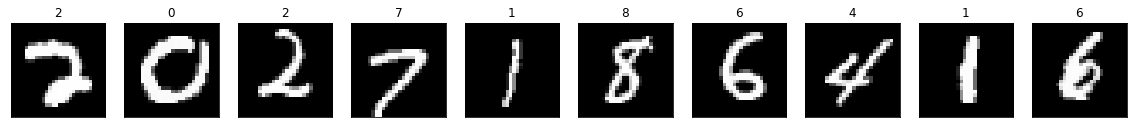

In [42]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [43]:
# Normalize values such that all numbers are within
# the range of 0 to 1

X_train = X_train/255
X_test = X_test/255

In [44]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print("Previous:")
print(X_train.shape)
print(X_test.shape)
print("Current:")
print(X_train_new.shape)
print(X_test_new.shape)

Previous:
(60000, 28, 28)
(10000, 28, 28)
Current:
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [45]:
# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

In [46]:
# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [47]:
# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps


In [48]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])


In [49]:
# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)
print(conv_shape)

(None, 14, 14, 16)


In [50]:
# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [51]:
# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [52]:
# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [53]:
if not os.path.exists("/tmp/weights/mnist"):
  os.makedirs("/tmp/weights")

In [54]:
# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
mnist_checkpoint_vae = ModelCheckpoint(filepath= "/tmp/weights/mnist/", save_weights_only = True, verbose=1)

In [55]:
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=60, batch_size=32, validation_data=(X_test_new,X_test_new),  callbacks=[mnist_checkpoint_vae])


Train on 60000 samples, validate on 10000 samples
Epoch 1/60
59968/60000 [============================>.] - ETA: 0s - loss: 188.8373

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: saving model to /tmp/weights/mnist/
60000/60000 [==============================] - 16s 264us/sample - loss: 188.8300 - val_loss: 174.0554
Epoch 2/60
59808/60000 [============================>.] - ETA: 0s - loss: 172.8458
Epoch 00002: saving model to /tmp/weights/mnist/
60000/60000 [==============================] - 15s 256us/sample - loss: 172.8431 - val_loss: 171.6728
Epoch 3/60
59840/60000 [============================>.] - ETA: 0s - loss: 170.5513
Epoch 00003: saving model to /tmp/weights/mnist/
60000/60000 [==============================] - 15s 258us/sample - loss: 170.5383 - val_loss: 169.2718
Epoch 4/60
59840/60000 [============================>.] - ETA: 0s - loss: 167.8902
Epoch 00004: saving model to /tmp/weights/mnist/
60000/60000 [==============================] - 15s 255us/sample - loss: 167.8724 - val_loss: 166.3561
Epoch 5/60
59840/60000 [============================>.] - ETA: 0s - loss: 165.6793
Epoch 00005: saving model to /tmp/weights/mnist/
60000/60000 [=

In [56]:
!zip -r /content/mnist.zip /tmp/weights/mnist
files.download("/content/mnist.zip")

updating: tmp/weights/mnist/ (stored 0%)
updating: tmp/weights/mnist/checkpoint (deflated 34%)
updating: tmp/weights/mnist/.index (deflated 69%)
updating: tmp/weights/mnist/.data-00000-of-00001 (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

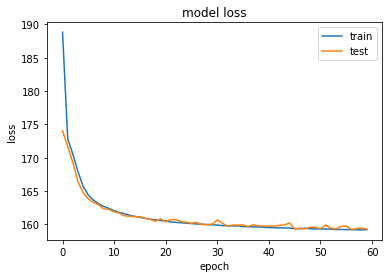

In [57]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [58]:
# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


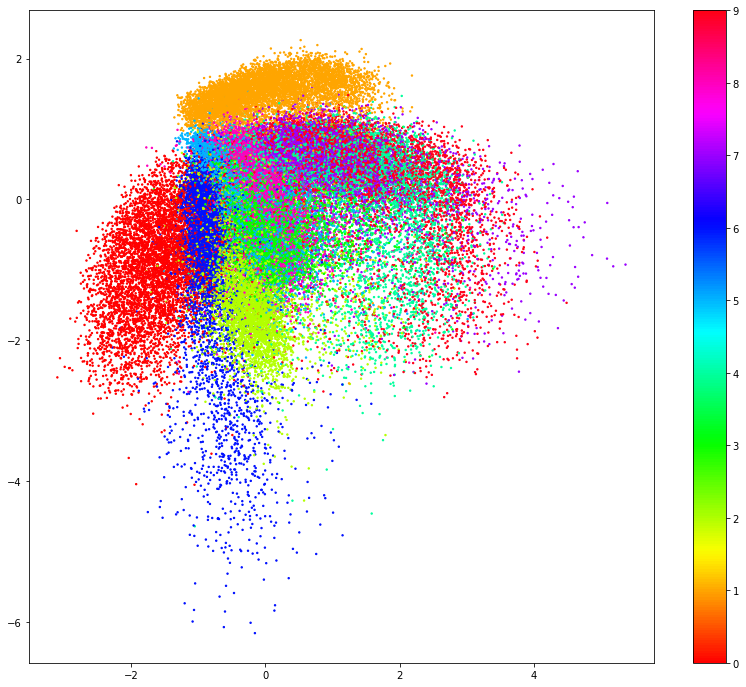

In [59]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()

In [60]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    print(new_points.shape)
    print(new_points)
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

(9, 2)
[[0.   2.  ]
 [0.25 1.75]
 [0.5  1.5 ]
 [0.75 1.25]
 [1.   1.  ]
 [1.25 0.75]
 [1.5  0.5 ]
 [1.75 0.25]
 [2.   0.  ]]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


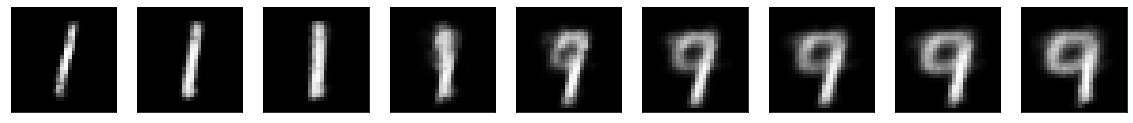

In [61]:
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

(9, 2)
[[-2.     1.   ]
 [-1.75   1.125]
 [-1.5    1.25 ]
 [-1.25   1.375]
 [-1.     1.5  ]
 [-0.75   1.625]
 [-0.5    1.75 ]
 [-0.25   1.875]
 [ 0.     2.   ]]


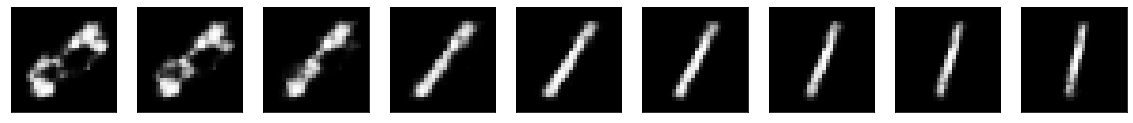

In [62]:
# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-2,1,0,2,9)

(19, 2)
[[ 0.         -2.        ]
 [ 0.         -1.77777778]
 [ 0.         -1.55555556]
 [ 0.         -1.33333333]
 [ 0.         -1.11111111]
 [ 0.         -0.88888889]
 [ 0.         -0.66666667]
 [ 0.         -0.44444444]
 [ 0.         -0.22222222]
 [ 0.          0.        ]
 [ 0.          0.22222222]
 [ 0.          0.44444444]
 [ 0.          0.66666667]
 [ 0.          0.88888889]
 [ 0.          1.11111111]
 [ 0.          1.33333333]
 [ 0.          1.55555556]
 [ 0.          1.77777778]
 [ 0.          2.        ]]


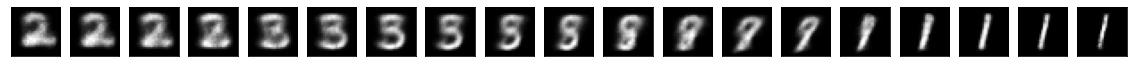

In [63]:
# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)

# **Fashion MNIST**

In [64]:
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

In [65]:
# Normalize values such that all numbers are within
# the range of 0 to 1

X_train_fashion = X_train_fashion/255
X_test_fashion = X_test_fashion/255
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_fashion_new = X_train_fashion.reshape(X_train_fashion.shape[0], X_train_fashion.shape[1], X_train_fashion.shape[2], 1)
X_test_fashion_new = X_test_fashion.reshape(X_test_fashion.shape[0], X_test_fashion.shape[1], X_test_fashion.shape[2], 1)

In [66]:
# Actually build encoder, decoder and the entire VAE
fencoder = Model(encoder_input, latent_space)
fdecoder = Model(decoder_input, decoder_conv)
fvae = Model(encoder_input, fdecoder(fencoder(encoder_input)))



In [67]:
if not os.path.exists("/tmp/weights/fmnist"):
  os.makedirs("/tmp/weights/fmnist")

In [68]:
fvae.compile(optimizer='adam', loss=kl_reconstruction_loss)
fmnist_checkpoint_vae = ModelCheckpoint(filepath= "/tmp/weights/fmnist/", save_weights_only = True, verbose=1)
history = fvae.fit(x=X_train_fashion_new, y=X_train_fashion_new, epochs=100, batch_size=32, validation_data=(X_test_fashion_new,X_test_fashion_new), callbacks=[fmnist_checkpoint_vae] )


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59872/60000 [============================>.] - ETA: 0s - loss: 301.1911

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: saving model to /tmp/weights/fmnist/
60000/60000 [==============================] - 16s 261us/sample - loss: 301.1575 - val_loss: 283.4657
Epoch 2/100
60000/60000 [==============================] - ETA: 0s - loss: 278.6771
Epoch 00002: saving model to /tmp/weights/fmnist/
60000/60000 [==============================] - 15s 253us/sample - loss: 278.6771 - val_loss: 278.2312
Epoch 3/100
59904/60000 [============================>.] - ETA: 0s - loss: 275.5608
Epoch 00003: saving model to /tmp/weights/fmnist/
60000/60000 [==============================] - 15s 250us/sample - loss: 275.5659 - val_loss: 276.3769
Epoch 4/100
59872/60000 [============================>.] - ETA: 0s - loss: 274.1025
Epoch 00004: saving model to /tmp/weights/fmnist/
60000/60000 [==============================] - 15s 251us/sample - loss: 274.1154 - val_loss: 274.9706
Epoch 5/100
59840/60000 [============================>.] - ETA: 0s - loss: 273.1526
Epoch 00005: saving model to /tmp/weights/fmnist/
60000

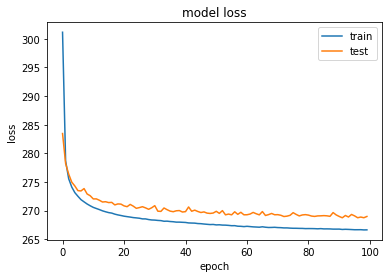

In [69]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [70]:
!zip -r /content/fmnist.zip /tmp/weights/fmnist
files.download("/content/fmnist.zip")

updating: tmp/weights/fmnist/ (stored 0%)
updating: tmp/weights/fmnist/checkpoint (deflated 34%)
updating: tmp/weights/fmnist/.index (deflated 69%)
updating: tmp/weights/fmnist/.data-00000-of-00001 (deflated 23%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
encoded = fencoder.predict(X_train_fashion_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


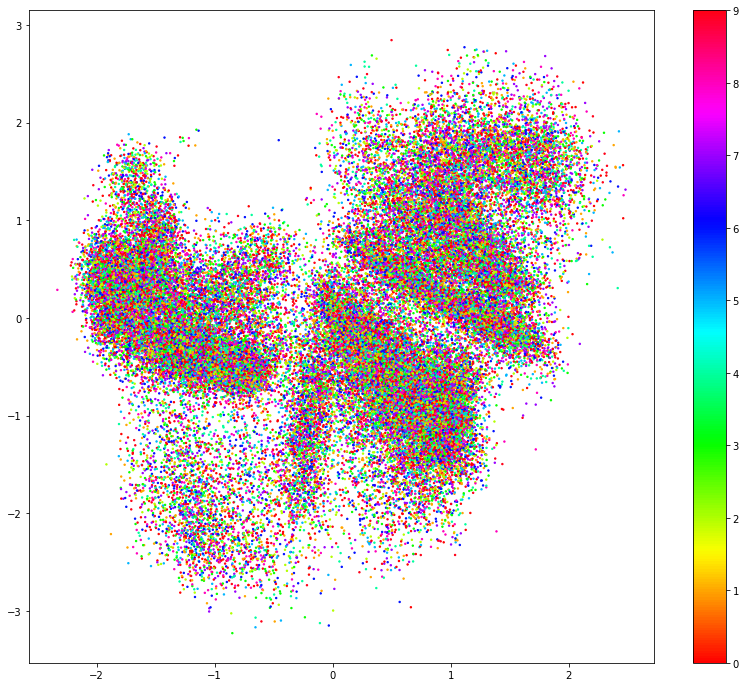

In [72]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()

(9, 2)
[[0.   2.  ]
 [0.25 1.75]
 [0.5  1.5 ]
 [0.75 1.25]
 [1.   1.  ]
 [1.25 0.75]
 [1.5  0.5 ]
 [1.75 0.25]
 [2.   0.  ]]


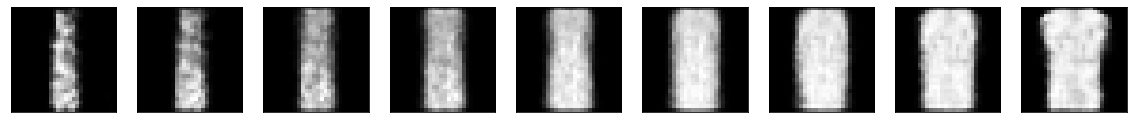

In [73]:
display_image_sequence(0,2,2,0,9)

TSNE

In [82]:
from sklearn.manifold import TSNE
import pandas as pd  
import seaborn as sns
import plotly.express as px

In [79]:
encoded_mnist = encoder.predict(X_test_new[:1000])
encoded_mnist.shape

(1000, 2)

In [81]:
encoded_fmnist = fencoder.predict(X_train_fashion_new[:1000])
encoded_fmnist.shape

(1000, 2)

In [83]:

tsne_mnist_2D = TSNE(2, verbose=1)
tsne_mnist_proj_2D = tsne_mnist_2D.fit_transform(encoded_mnist)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.080842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.554695
[t-SNE] KL divergence after 1000 iterations: 0.455515


In [84]:
tsne_fmnist_2D = TSNE(2, verbose=1)
tsne_fmnist_proj_2D = tsne_fmnist_2D.fit_transform(encoded_fmnist)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.175067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.384483
[t-SNE] KL divergence after 1000 iterations: 0.368484


In [86]:
df_2D_mnist = pd.DataFrame()
df_2D_mnist["Component_1"] = tsne_mnist_proj_2D[:,0]
df_2D_mnist["Component_2"] = tsne_mnist_proj_2D[:,1]
df_2D_mnist["y"] = ["0"] * 1000

In [88]:
df_2D_fmnist = pd.DataFrame()
df_2D_fmnist["Component_1"] = tsne_fmnist_proj_2D[:,0]
df_2D_fmnist["Component_2"] = tsne_fmnist_proj_2D[:,1]
df_2D_fmnist["y"] = ["1"] * 1000

In [89]:
df = pd.DataFrame()
df = df.append(df_2D_mnist)
df = df.append(df_2D_fmnist)

[Text(0.5, 1.0, 'T-SNE projection')]

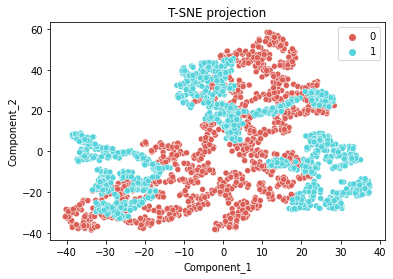

In [90]:
sns.scatterplot(x="Component_1", y="Component_2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="T-SNE projection")

In [98]:
encoded_mnist = encoder.predict(X_train_new)
encoded_fmnist = fencoder.predict(X_train_fashion_new)



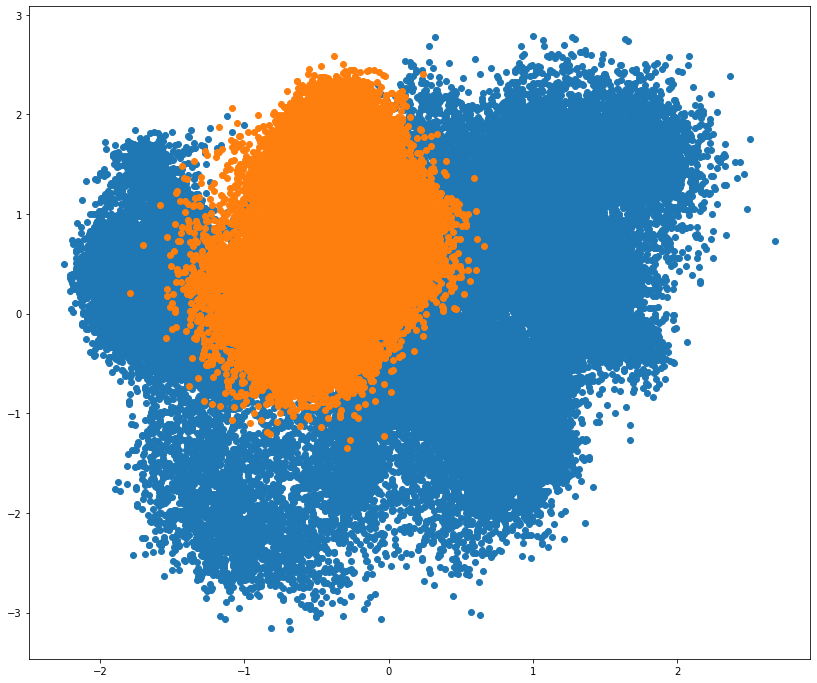

In [99]:

plt.figure(figsize=(14,12))
plt.scatter(encoded_fmnist[:,0], encoded_fmnist[:,1])
plt.scatter(encoded_mnist[:,0], encoded_mnist[:,1])

In [102]:
encoded_mnist = encoder.predict(X_train_new[:3])
print(encoded_mnist)

encoded_fmnist = fencoder.predict(X_train_fashion_new[:3])
print(encoded_fmnist)

[[-0.11209973  0.5521805 ]
 [-0.30195248  1.0983483 ]
 [-0.6179919   1.0804162 ]]
[[-0.8890773  -0.6945593 ]
 [ 1.2477096  -0.26341704]
 [ 0.6607509   1.1727387 ]]


(10, 2)
[[ 1.          2.        ]
 [ 0.79010252  1.70060452]
 [ 0.58020504  1.40120904]
 [ 0.37030757  1.10181357]
 [ 0.16041009  0.80241809]
 [-0.04948739  0.50302261]
 [-0.25938487  0.20362713]
 [-0.46928234 -0.09576834]
 [-0.67917982 -0.39516382]
 [-0.8890773  -0.6945593 ]]


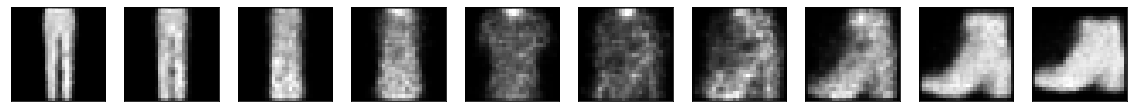

In [106]:
display_image_sequence(1,2,-0.8890773,-0.6945593,10)
display_image_sequence(1,2,-0.8890773,-0.6945593,10)   